# 군집화 실습 - 고객 세그멘테이션 실습
- 고객을 구매 패턴에 따라 세그먼트화하여 마케팅 전략 수립, 고객 관리, 매출 증대 등의 비즈니스 의사결정에 활용할 수 있는 RFM 분석을 수행

데이터 다운로드하기
- https://archive.ics.uci.edu/datasets?search
- 데이터 다운로드 : https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
# warning 무시
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
# '-' 깨짐 해결 모듈
import matplotlib as mpl

plt.rcParams["font.family"] = "Malgun Gothic"  # For Windows
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8,4)
print(plt.rcParams["font.family"])

# 마이너스 깨짐 해결
mpl.rcParams["axes.unicode_minus"] = False

['Malgun Gothic']


## 데이터 셋 로딩과 데이터 클린징

In [2]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

## UCI Online_Retai 데이터 구조
- InvoiceNo : 각 거래에 고유하게 할당된 6자리 정수, 이 코드가 문자 'c'로 시작하면 취소를 나타냄
- StockCode : 각 개별 제품에 고유하게 할당된 5자리 정수
- Description : product name
- Quantity : 거래당 각 제품(항목)의 수량
- InvoiceDate : 각 거래가 발생한 날짜와 시간
- UnitPrice : 단위당 제품 가격
- CustomerID : 각 고객에게 고유하게 할당된 5자리 정수
- Country : 각 고객이 거주하는 국가의 이름

In [3]:
# 데이터 로딩
data_path = "datas_ml/Online_Retail.xlsx"
retail_df = pd.read_excel(io=data_path)
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail_df['Country'].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [6]:
# Quantity 컬럼에 0보다 작은 값의 갯수
(retail_df['Quantity']< 0).sum()

np.int64(10624)

In [7]:
# UnitPrice 컬럼에 0보다 작은 값의 갯수
(retail_df['UnitPrice'] < 0).sum()

np.int64(2)

In [8]:
retail_df['CustomerID'].isnull().sum()

np.int64(135080)

# 데이터 전처리

### 데이터 전처리 계획
- Quantity : 수량이 0이거나 음수인 거래는 제거함
- UnitPrice : 단가가 0이거나 음수인 비정상 거래는 제거
- CustomerID : 고객 정보가 없는 거래는 분석에서 제외함
- United Kingdom 데이터만 사용한다.

In [9]:
# 수량이 0이거나 음수인(예: 반품, 오류 등) 거래는 제거
retail_df = retail_df.loc[retail_df['Quantity'] > 0]
# 단가가 0이거나 음수인 비정상 거래를 제거
retail_df = retail_df.loc[retail_df['UnitPrice'] > 0]
# 고객 정보가 없는 거래는 분석에서 제외
retail_df = retail_df.loc[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

- 영국 이외 국가의 데이터는 제외하기

In [11]:
retail_df = retail_df.loc[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


In [12]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


### RFM 기반 데이터 가공
- RECENCY (R) : 가장 최근 상품 구입 일에서 오늘까지의 기간(마지막 구매 이후 경과 시간)
- FREQUENCY (F) : 고객별 상품 구매 횟수
- MONETARY VALUE (M) : 고객별 총 구매 금액

#### 각 행의 sale_amount 계산 및 컬럼 타입변환

In [13]:
# 갯수 * 단위금액
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
# 고객 id : float -> int
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [14]:
print(retail_df['CustomerID'].value_counts().head(5))

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64


In [15]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [16]:
# 고객 별 구매 금액 계산 확인
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [17]:
# 고객이 한 번 거래(송장번호 기준)에서 각 상품 구매 갯수
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().sort_values(ascending=False)

InvoiceNo  StockCode
555524     22698        20
           22697        12
572861     22775         8
572344     M             7
578289     23395         7
                        ..
581585     84946         1
581586     20685         1
           21217         1
           22061         1
           23275         1
Name: InvoiceNo, Length: 344435, dtype: int64

In [18]:
# 고객이 한 번 거래(송장번호 기준)에서 각 상품을 평균적으로 몇 개씩 구매하는지 보기
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

#### 각 고객 기준으로 Recency, Frequency, Monetary가공

In [19]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',   # 각 고객의 가장 최근 구매 날짜를 찾기 위해 InvoiceDate 컬럼의 최대값(가장 최근 날짜)을 구함
    'InvoiceNo': 'count',   # 각 고객의 총 구매 횟수(빈도)를 계산하기 위해 InvoiceNo 컬럼의 개수를 카운트
    'sale_amount':'sum'     # 각 고객의 총 구매 금액을 계산하기 위해 sale_amount 컬럼의 합계를 구함
}
cust_rfm_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_rfm_df

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34
...,...,...,...
18280,2011-03-07 09:52:00,10,180.60
18281,2011-06-12 10:53:00,7,80.82
18282,2011-12-02 11:43:00,12,178.05


- 가독성이 높도록 컬럼 이름 변경(Recency, Frequency, Monetary)로

In [20]:
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_rfm_df = cust_rfm_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_rfm_df = cust_rfm_df.reset_index()
cust_rfm_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


 #### 고객의 마지막 구매 이후 경과된 일수 구하기

In [21]:
# Recency 열에서 가장 마지말 날짜 확인
cust_rfm_df['Recency'].max()

Timestamp('2011-12-09 12:49:00')

- 2011-12-09까지의 거래 데이터라고 하고, 다음날 분석한다고 가정함

In [22]:
import datetime as dt
dt.datetime(2011,12,10)

datetime.datetime(2011, 12, 10, 0, 0)

In [23]:
cust_rfm_df['Recency']

0      2011-01-18 10:01:00
1      2011-12-07 14:34:00
2      2011-12-09 12:20:00
3      2011-12-06 09:56:00
4      2011-12-06 15:12:00
               ...        
3915   2011-03-07 09:52:00
3916   2011-06-12 10:53:00
3917   2011-12-02 11:43:00
3918   2011-12-06 12:02:00
3919   2011-10-28 09:29:00
Name: Recency, Length: 3920, dtype: datetime64[ns]

In [24]:
# 기간 인터발 계산방법
# dt.datetime(2011,12,10) - cust_rfm_df['Recency']
(dt.datetime(2011,12,10) - cust_rfm_df['Recency']).apply(lambda x: x.days+1)

0       326
1         3
2         1
3         4
4         4
       ... 
3915    278
3916    181
3917      8
3918      4
3919     43
Name: Recency, Length: 3920, dtype: int64

In [25]:
# 각 고객의 마지막 구매일로부터 이 기준 날짜까지의 경과 시간을 계산
cust_rfm_df['Recency'] = dt.datetime(2011,12,10) - cust_rfm_df['Recency']
cust_rfm_df['Recency'] = cust_rfm_df['Recency'].apply(lambda x: x.days+1)  # 기간 인터발이 나옴
print('cust_rfm_df 로우와 컬럼 건수는 ',cust_rfm_df.shape)
cust_rfm_df.head(3)

cust_rfm_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


## RFM 기반 고객 세그먼테이션 시각화

**Recency, Frequency, Monetary 값의 분포도 확인**

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

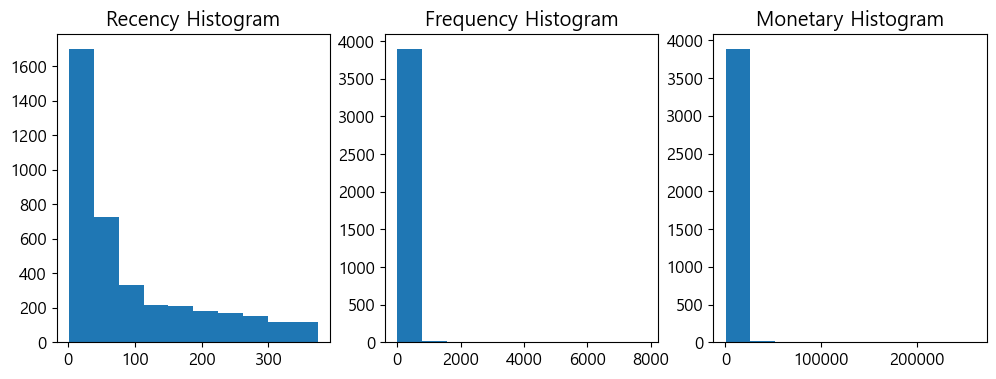

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_rfm_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_rfm_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_rfm_df['Monetary'])

In [27]:
cust_rfm_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- Recency : 중위값과 평균의 차이 비교해보면, 오랫동안 접속을 안한 사람들이 많음
- Frequency : 중위값, 평균, max값과 차이가 심함

## K-Means로 군집화 후에 실루엣 계수 평가

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_rfm_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_rfm_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.576


## K-Means 군집화 후에 실루엣 계수 및 군집을 시각화

### 실루엣 계수 시각화 함수 정의

In [29]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

### 군집 결과 시각화 함수 정의

In [30]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

### 실루엣 계수 시각화

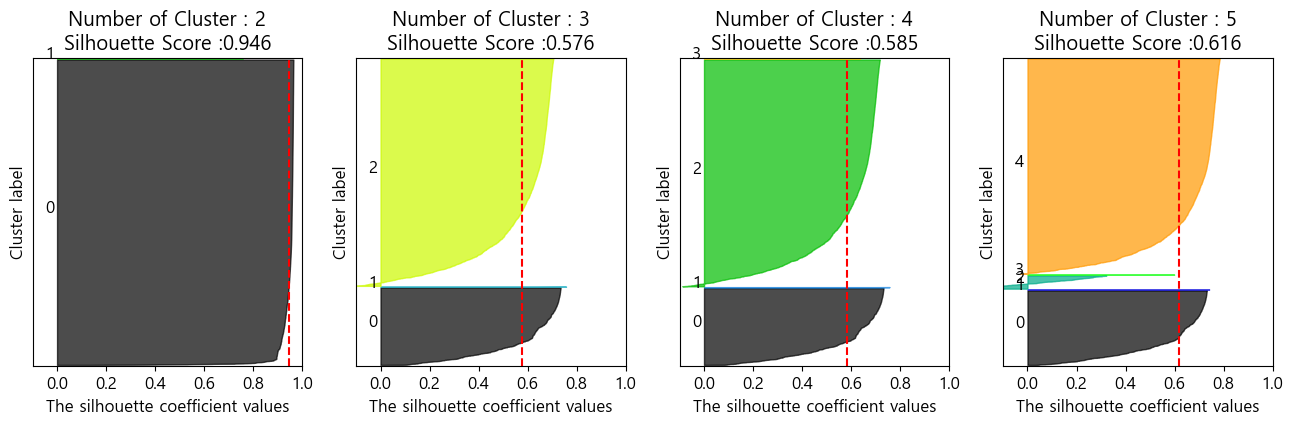

In [31]:
visualize_silhouette([2,3,4,5],X_features_scaled)

### 군집 결과 시각화

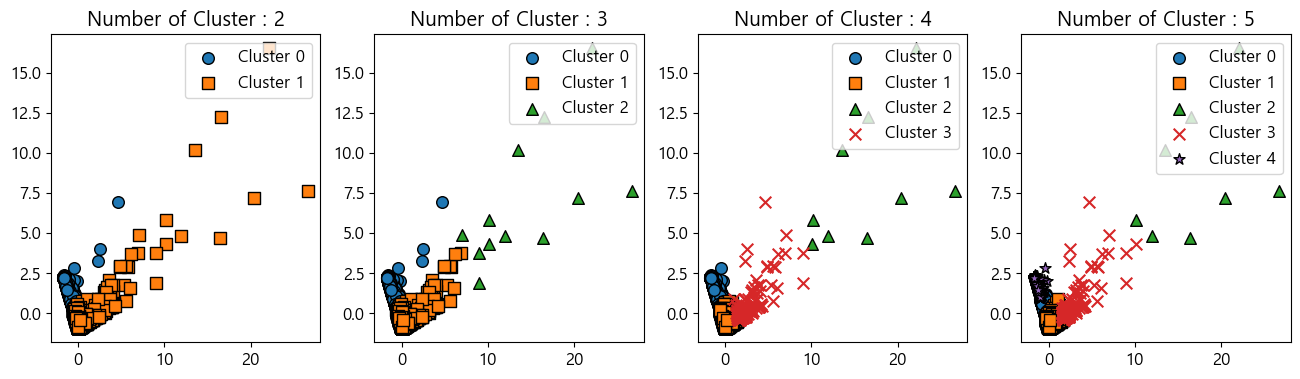

In [32]:
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

## log 변환 후 재 시각화
- log 변환 이유 : K-Means는 **유클리디안 거리(Euclidean distance)**를 기반으로 군집을 나누기 때문에,
특정 피처(변수)에 극단적으로 큰 값들이 있음.
- 즉, 스케일이 큰 값이 군집화를 왜곡시킬 수 있음
- 로그 변환의 효과:
    - 스케일 차이 축소: 큰 값과 작은 값의 차이를 줄여줌
    - 분포 정규화: 비대칭적인(오른쪽으로 긴) 데이터를 더 대칭적으로 만들어줌
    - 이상치 완화: 이상치가 덜 극단적으로 보이게 됨

In [33]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation 
# -> 정규분포를 따르도록 변환함, 결과적으로 큰값의 영향도를 줄일 수 있음.
cust_rfm_df['Recency_log'] = np.log1p(cust_rfm_df['Recency'])
cust_rfm_df['Frequency_log'] = np.log1p(cust_rfm_df['Frequency'])
cust_rfm_df['Monetary_log'] = np.log1p(cust_rfm_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_rfm_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_rfm_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.303


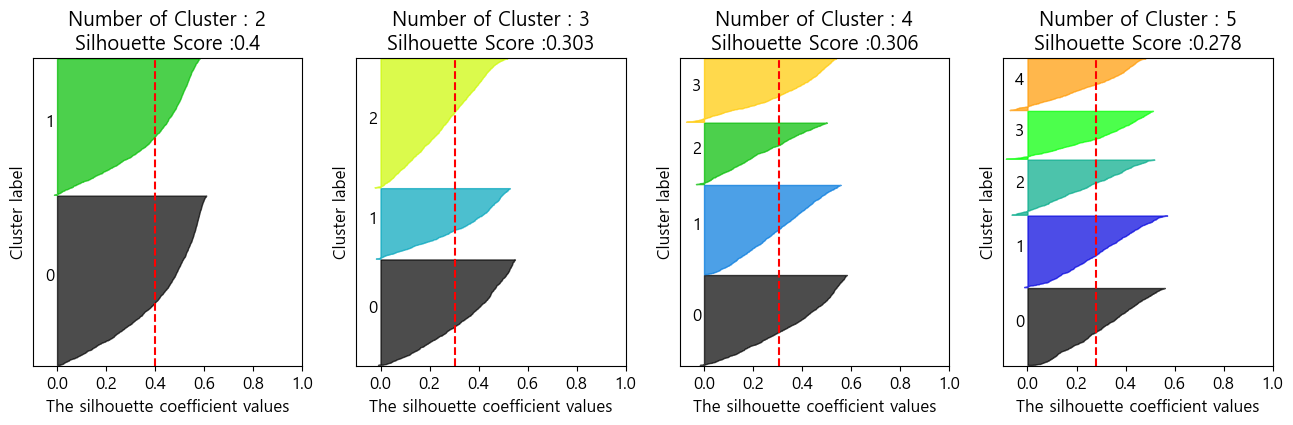

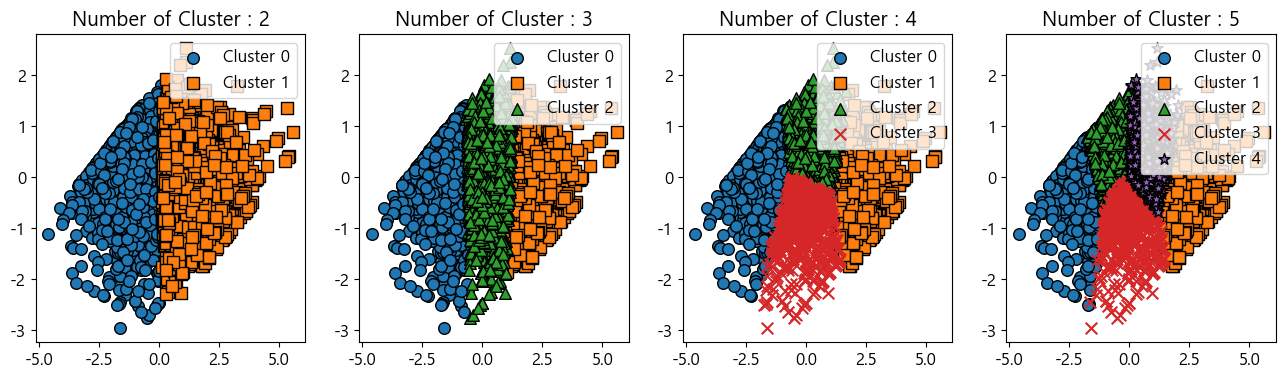

In [34]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)